# Diffusion Maps + KSWGD Generative Modelling on CIFAR-10

This notebook implements an autoencoder + diffusion-maps latent analysis, then mirrors the KSWGD scheme from Tests 1 & 2 to sample new CIFAR-10 images directly in latent space.

**Dataset: CIFAR-10**
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- 32×32 RGB color images (3 channels)
- 50,000 training / 10,000 test images

**Pipeline:**

1. Load CIFAR-10 and normalize images.
2. Train an autoencoder (either MLP-based or CNN-based) to learn a low-dimensional latent space.
3. Map training images to latent codes.
4. Apply Diffusion Maps on latent codes to obtain diffusion coordinates for diagnostics.
5. Build the KSWGD kernel operators on the latent samples (same normalization as Tests 1 & 2).
6. Run KSWGD particle transport to draw new latent vectors.
7. Decode KSWGD latent vectors back to images and visually inspect generated images.

In [1]:
# Configure core libraries, plotting defaults, and compute device
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.sparse.linalg import eigs
from scipy.linalg import eig
from tqdm.auto import trange
import diffusers
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    TORCHMETRICS_AVAILABLE = True
except ImportError:
    FrechetInceptionDistance = None
    TORCHMETRICS_AVAILABLE = False

from grad_ker1 import grad_ker1
from K_tar_eval import K_tar_eval

try:
    import cupy as cp
    from grad_ker1_gpu import grad_ker1 as grad_ker1_gpu
    from K_tar_eval_gpu import K_tar_eval as K_tar_eval_gpu
    GPU_AVAILABLE = True
except Exception:
    cp = None
    grad_ker1_gpu = None
    K_tar_eval_gpu = None
    GPU_AVAILABLE = False

np.random.seed(1)
torch.manual_seed(1)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 120

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_gpu_kswgd = bool(GPU_AVAILABLE and torch.cuda.is_available())

print(f"Diffusers version: {diffusers.__version__}")

print("=" * 50)
print("GPU Info")
print("=" * 50)
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}, Memory: {props.total_memory / 1024**3:.2f} GB")
else:
    print("No CUDA GPU available")

print(f"\nUsing device: {device}")
print(f"KSWGD GPU backend: {'enabled' if use_gpu_kswgd else 'disabled'}")

Diffusers version: 0.36.0
GPU Info
CUDA version: 12.8
cuDNN version: 91002
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 5050 Laptop GPU, Memory: 7.96 GB

Using device: cuda
KSWGD GPU backend: enabled


In [2]:
# Load CIFAR-10 datasets and build training/test data loaders
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 1], shape: 3x32x32
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset), "Test size:", len(test_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Classes:", train_dataset.classes)
print("Image shape: 3x32x32 (RGB color)")

Train size: 50000 Test size: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image shape: 3x32x32 (RGB color)


In [3]:
# Load a pretrained Stable Diffusion VAE and wrap it for CIFAR-10 usage
vae_repo_id = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(
    vae_repo_id,
    torch_dtype=torch.float32,
 )
vae = vae.to(device)
vae_scaling = float(getattr(vae.config, "scaling_factor", 0.18215))

# Freeze the encoder except for the last down block (optional fine-tuning target)
for param in vae.encoder.parameters():
    param.requires_grad = False
for param in vae.encoder.down_blocks[-1].parameters():
    param.requires_grad = True

print("Loaded VAE:", vae_repo_id)
print("Latent channels:", vae.config.latent_channels)
print("Scaling factor:", vae_scaling)


def _to_vae_range(x: torch.Tensor) -> torch.Tensor:
    """Map [0, 1] RGB tensors to [-1, 1] for the SD VAE."""
    return (x * 2.0) - 1.0


def _from_vae_range(x: torch.Tensor) -> torch.Tensor:
    """Map [-1, 1] outputs back to [0, 1]."""
    return torch.clamp((x + 1.0) * 0.5, 0.0, 1.0)


class DiffusersAutoencoderWrapper(nn.Module):
    """Thin wrapper so downstream cells can keep using the `autoencoder` API."""

    def __init__(self, vae: AutoencoderKL, device: torch.device, image_size: int = 32):
        super().__init__()
        self.vae = vae
        self.device = device
        self.scaling_factor = float(getattr(vae.config, "scaling_factor", 0.18215))
        with torch.no_grad():
            dummy = torch.zeros(1, 3, image_size, image_size, device=device)
            latent = self.vae.encode(_to_vae_range(dummy)).latent_dist.mode()
        self.latent_shape = latent.shape[1:]
        self.latent_dim = int(np.prod(self.latent_shape))

    def encode_latents(self, images: torch.Tensor) -> torch.Tensor:
        posterior = self.vae.encode(_to_vae_range(images))
        latents = posterior.latent_dist.mode() * self.scaling_factor
        return latents

    def decode_latents(self, latents: torch.Tensor) -> torch.Tensor:
        decoded = self.vae.decode(latents / self.scaling_factor).sample
        return _from_vae_range(decoded)

    def encode(self, images: torch.Tensor) -> torch.Tensor:
        latents = self.encode_latents(images)
        return latents.view(latents.size(0), -1)

    def decode(self, flat_latents: torch.Tensor) -> torch.Tensor:
        latents = flat_latents.view(-1, *self.latent_shape)
        return self.decode_latents(latents)

    def forward(self, images: torch.Tensor):
        latents_flat = self.encode(images)
        recon = self.decode(latents_flat)
        return recon, latents_flat


autoencoder = DiffusersAutoencoderWrapper(vae, device=device, image_size=32).to(device)
autoencoder.eval()
latent_dim = autoencoder.latent_dim
print(f"Autoencoder wrapper latent dim: {autoencoder.latent_dim}")

Loaded VAE: stabilityai/sd-vae-ft-mse
Latent channels: 4
Scaling factor: 0.18215
Autoencoder wrapper latent dim: 64


In [4]:
# Optional fine-tuning utilities for adapting the pretrained VAE to CIFAR-10

def finetune_vae(
    model,
    dataloader,
    epochs=5,
    lr=1e-5,
    max_batches=None,
):
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    if not trainable_params:
        print("No trainable parameters detected; skipping fine-tuning.")
        return

    optimizer = torch.optim.Adam(trainable_params, lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        steps = 0
        for step, (imgs, _) in enumerate(dataloader):
            if max_batches is not None and step >= max_batches:
                break
            imgs = imgs.to(device)
            latents = model.encode(_to_vae_range(imgs)).latent_dist.sample()
            recon = model.decode(latents).sample
            recon_rgb = _from_vae_range(recon)
            loss = loss_fn(recon_rgb, imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            steps += 1
        avg_loss = running_loss / max(1, steps)
        print(f"[VAE FT] epoch {epoch + 1}/{epochs} | loss={avg_loss:.5f}")
    model.eval()
    print("Finished VAE fine-tuning.")

In [5]:
# Execute (optional) VAE fine-tuning before reconstruction diagnostics
do_finetune = False
finetune_epochs = 5
finetune_lr = 1e-5
finetune_max_batches = None  # e.g., set to 200 for a quick pass

if do_finetune:
    print(f"Fine-tuning VAE for {finetune_epochs} epochs at lr={finetune_lr}")
    finetune_vae(
        vae,
        train_loader,
        epochs=finetune_epochs,
        lr=finetune_lr,
        max_batches=finetune_max_batches,
    )
else:
    print("Skipping VAE fine-tuning (set do_finetune=True to enable).")

vae.eval()
autoencoder.eval()

Skipping VAE fine-tuning (set do_finetune=True to enable).


DiffusersAutoencoderWrapper(
  (vae): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlo

In [6]:
# Reconstruction diagnostics utilities for the pretrained VAE

def evaluate_vae_reconstruction(
    model: AutoencoderKL,
    dataloader: DataLoader,
    device: torch.device,
    num_batches: int = 1,
):
    model.eval()
    mse_loss = nn.MSELoss(reduction="mean")
    mse_values = []
    originals = []
    reconstructions = []

    with torch.no_grad():
        for batch_idx, (imgs, _) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            imgs = imgs.to(device)
            latents = model.encode(_to_vae_range(imgs)).latent_dist.mode() * vae_scaling
            recon = model.decode(latents / vae_scaling).sample
            recon_rgb = _from_vae_range(recon)
            loss = mse_loss(recon_rgb, imgs)

            mse_values.append(loss.item())
            originals.append(imgs.cpu())
            reconstructions.append(recon_rgb.cpu())

    if not mse_values:
        raise RuntimeError("No batches were evaluated; increase num_batches.")

    mean_mse = float(np.mean(mse_values))
    psnr = -10.0 * np.log10(mean_mse + 1e-8)

    originals = torch.cat(originals, dim=0)
    reconstructions = torch.cat(reconstructions, dim=0)

    return {
        "mse": mean_mse,
        "psnr": psnr,
        "originals": originals,
        "reconstructions": reconstructions,
    }

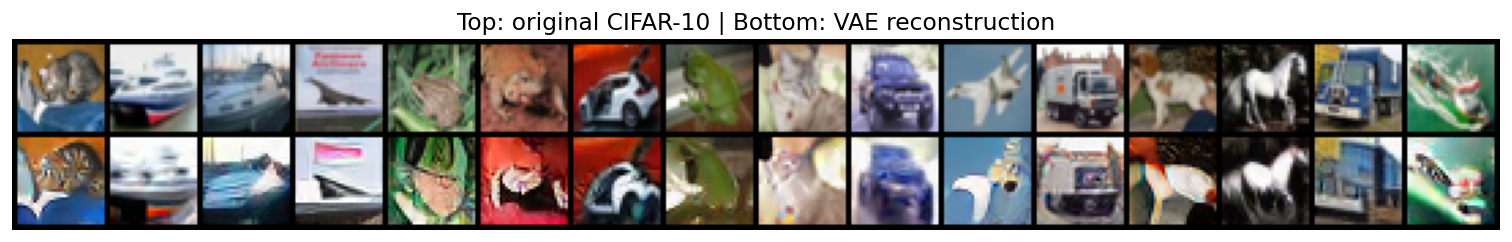

Reconstruction MSE=0.021395 | PSNR=16.70 dB
Status: TUNE (threshold=0.003)
Frechet Inception Distance unavailable (install torchmetrics>=1.0)


In [7]:
# Evaluate reconstructions (Cell 8) and visualize originals vs. reconstructions
num_eval_batches = 2
recon_report = evaluate_vae_reconstruction(
    vae,
    test_loader,
    device=device,
    num_batches=num_eval_batches,
)

orig_samples = recon_report["originals"][:16]
recon_samples = recon_report["reconstructions"][:16]
comparison = torch.cat([orig_samples, recon_samples], dim=0)

grid = make_grid(comparison, nrow=16)
plt.figure(figsize=(16, 2.5))
plt.imshow(np.clip(grid.permute(1, 2, 0).numpy(), 0.0, 1.0))
plt.axis("off")
plt.title("Top: original CIFAR-10 | Bottom: VAE reconstruction", fontsize=14)
plt.show()

mse = recon_report["mse"]
psnr = recon_report["psnr"]
print(f"Reconstruction MSE={mse:.6f} | PSNR={psnr:.2f} dB")
quality_flag = "PASS" if mse < 3e-3 else "TUNE"
print(f"Status: {quality_flag} (threshold=0.003)")

if TORCHMETRICS_AVAILABLE and FrechetInceptionDistance is not None:
    fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)
    real_batch = recon_report["originals"].to(device)
    fake_batch = recon_report["reconstructions"].to(device)
    fid_metric.update(real_batch, real=True)
    fid_metric.update(fake_batch, real=False)
    fid_score = float(fid_metric.compute().cpu())
    print(f"Frechet Inception Distance (orig vs recon) = {fid_score:.3f}")
else:
    print("Frechet Inception Distance unavailable (install torchmetrics>=1.0)")

In [8]:
# Encode the full training set to collect latent vectors and labels for DM
autoencoder.eval()

all_latents = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, z = autoencoder(images)
        all_latents.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

Z = np.concatenate(all_latents, axis=0)   # shape (N, latent_dim)
y_labels = np.concatenate(all_labels, axis=0)

print("Latent codes shape:", Z.shape)


Latent codes shape: (50000, 64)


In [9]:
# Prepare the latent sample subset and kernel matrix required for diffusion maps
# Subsample for Diffusion Maps (e.g., 5000 points) with stratified sampling to keep label balance
max_dm_samples = 500  # DEBUG: reduced from 20000
N_total = Z.shape[0]

if N_total > max_dm_samples:
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_dm_samples, random_state=42)
    idx_dm, _ = next(splitter.split(Z, y_labels))
else:
    idx_dm = np.arange(N_total)

Z_dm_raw = Z[idx_dm]
labels_dm = y_labels[idx_dm]

# ========== STANDARDIZE latent codes for DM ==========
# This ensures all dimensions have similar scale for proper kernel computation
Z_dm_mean = np.mean(Z_dm_raw, axis=0, keepdims=True)
Z_dm_std = np.std(Z_dm_raw, axis=0, keepdims=True) + 1e-8
Z_dm = (Z_dm_raw - Z_dm_mean) / Z_dm_std  # Standardized latent codes
print(f"Standardized Z_dm: mean~{Z_dm.mean():.4f}, std~{Z_dm.std():.4f}")
# =====================================================

unique_labels, label_counts = np.unique(labels_dm, return_counts=True)
label_hist = {int(lbl): int(cnt) for lbl, cnt in zip(unique_labels, label_counts)}
print("Latent points used for DM:", Z_dm.shape)
print("Label histogram in DM subset:", label_hist)

# Pairwise distances (now on standardized data)
dists = pairwise_distances(Z_dm, metric="euclidean")

# Epsilon via median heuristic (can adjust multiplier for better separation)
med_sq = np.median(dists**2)
eps = med_sq / (2.0 * np.log(Z_dm.shape[0]))
# Alternative: use a smaller epsilon for tighter clustering
# eps = np.percentile(dists**2, 10)  # 10th percentile for local structure
print("Chosen epsilon:", eps)
print(f"Distance stats: min={dists[dists>0].min():.4f}, median={np.median(dists):.4f}, max={dists.max():.4f}")

# Gaussian kernel
K = np.exp(-dists**2 / (2.0 * eps))

# Row-normalize -> Markov matrix P
row_sums = K.sum(axis=1, keepdims=True)
P = K / row_sums

Standardized Z_dm: mean~0.0000, std~1.0000
Latent points used for DM: (500, 64)
Label histogram in DM subset: {0: 50, 1: 50, 2: 50, 3: 50, 4: 50, 5: 50, 6: 50, 7: 50, 8: 50, 9: 50}
Chosen epsilon: 10.075009563168699
Distance stats: min=5.8774, median=11.1904, max=18.4911


In [10]:
# Compute the leading diffusion-map eigenpairs to obtain coordinates and spectra
import time
from IPython.display import display, clear_output
import ipywidgets as widgets

m = 10  # DEBUG: reduced from 32
t_diffusion = 1  # diffusion time for scaling coordinates

# Create progress bar widget
progress_bar = widgets.FloatProgress(
    value=0, min=0, max=100, 
    description='Computing:', 
    bar_style='info',
    style={'bar_color': '#00a0dc', 'description_width': '80px'},
    layout=widgets.Layout(width='80%')
)
status_label = widgets.HTML(value="<b>Starting eigenvalue decomposition...</b>")
time_label = widgets.HTML(value="")
display(widgets.VBox([progress_bar, status_label, time_label]))

# Estimate computation based on matrix size
n_samples = P.shape[0]
print(f"Matrix size: {n_samples} x {n_samples}, computing {m} eigenvectors...")

start_time = time.time()

# Update progress - phase 1: preparation
progress_bar.value = 10
status_label.value = "<b>Phase 1/3:</b> Preparing matrix transpose..."
time.sleep(0.1)

# Compute eigenvalues with progress updates
progress_bar.value = 20
status_label.value = "<b>Phase 2/3:</b> Computing eigenvalue decomposition (this may take a while)..."

# The actual computation
vals, vecs = eigs(P.T, k=m, which="LR")

# Update progress - phase 3: post-processing
progress_bar.value = 80
elapsed = time.time() - start_time
status_label.value = "<b>Phase 3/3:</b> Sorting and scaling eigenvectors..."
time_label.value = f"<i>Eigenvalue computation took: {elapsed:.1f} seconds</i>"

idx_sort = np.argsort(-np.abs(vals))
vals = vals[idx_sort]
vecs = vecs[:, idx_sort]

lam = np.real(vals)
phi_raw = np.real(vecs)

# Scale diffusion coordinates by eigenvalues^t (standard Diffusion Maps embedding)
# This amplifies the coordinates to show structure at different scales
phi = phi_raw * (lam[np.newaxis, :] ** t_diffusion)

# Finalize progress
progress_bar.value = 100
progress_bar.bar_style = 'success'
total_time = time.time() - start_time
status_label.value = "<b style='color: green;'>✓ Completed!</b>"
time_label.value = f"<i>Total time: {total_time:.1f} seconds</i>"

print(f"\n{'='*50}")
print("Leading eigenvalues:", lam)
print(f"Diffusion coords range: [{phi[:, 1:].min():.4f}, {phi[:, 1:].max():.4f}]")

Matrix size: 500 x 500, computing 10 eigenvectors...

Leading eigenvalues: [1.         0.89271918 0.87024627 0.75482397 0.73614597 0.72113666
 0.70762485 0.70246955 0.69636015 0.69378857]
Diffusion coords range: [-0.8744, 0.8526]


c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


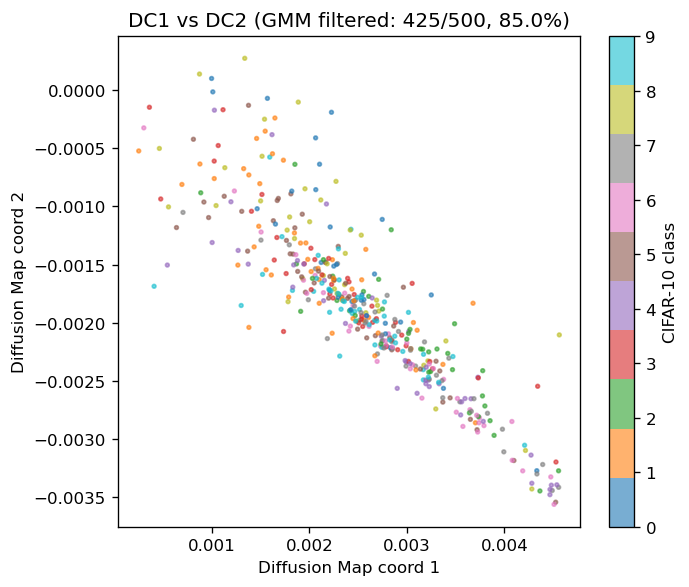

c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


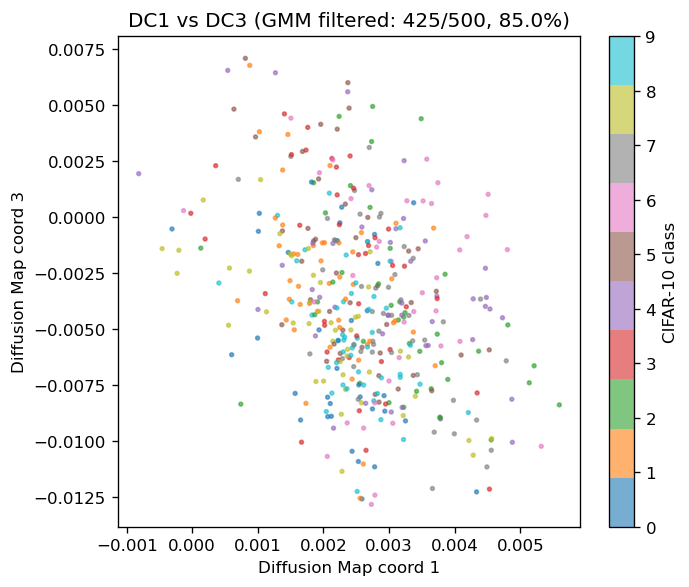

c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


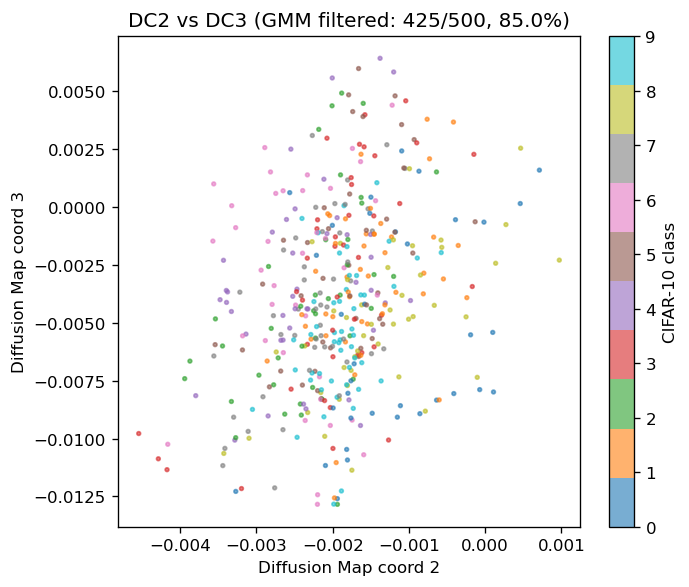

In [11]:
# Plot several diffusion-coordinate pairs with GMM outlier filtering (keep ~90% of points)
from sklearn.mixture import GaussianMixture

# GMM outlier filtering parameters
n_gmm_components_2d = 10  # number of GMM components
outlier_percentile = 15   # remove bottom 10% by GMM log-likelihood (keep 90%)

pairs = [(1, 2), (1, 3), (2, 3)]
for i, j in pairs:
    dc_i = phi[:, i]
    dc_j = phi[:, j]
    coords_2d = np.column_stack([dc_i, dc_j])
    
    # Fit GMM and compute log-likelihood scores
    gmm_2d = GaussianMixture(n_components=n_gmm_components_2d, covariance_type='full', random_state=42)
    gmm_2d.fit(coords_2d)
    log_probs_2d = gmm_2d.score_samples(coords_2d)
    
    # Keep top 90% by log-likelihood (filter out bottom 10% outliers)
    threshold_2d = np.percentile(log_probs_2d, outlier_percentile)
    inlier_mask_2d = log_probs_2d >= threshold_2d
    
    n_total = len(dc_i)
    n_kept = np.sum(inlier_mask_2d)
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(dc_i[inlier_mask_2d], dc_j[inlier_mask_2d], 
                          c=labels_dm[inlier_mask_2d], s=5, alpha=0.6, cmap="tab10")
    plt.xlabel(f"Diffusion Map coord {i}")
    plt.ylabel(f"Diffusion Map coord {j}")
    plt.title(f"DC{i} vs DC{j} (GMM filtered: {n_kept}/{n_total}, {100*n_kept/n_total:.1f}%)")
    plt.colorbar(scatter, label="CIFAR-10 class")
    plt.tight_layout()
    plt.show()

Raw coordinate ranges (before filtering):
  DC1: [-0.7806, 0.0064]
  DC2: [-0.1380, 0.7420]
  DC3: [-0.0116, 0.5340]

IQR pre-filter: removed 46 extreme points (9.2%)
GMM filter: removed additional 46 points
Total outliers removed: 92 (18.4%)
Inliers kept: 408

Filtered & scaled coordinate ranges (SPREAD_FACTOR=1.5):
  DC1: [-4.057, 4.104]
  DC2: [-3.661, 4.228]
  DC3: [-2.379, 3.091]


c:\Users\xyc93\miniconda3\envs\torch\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


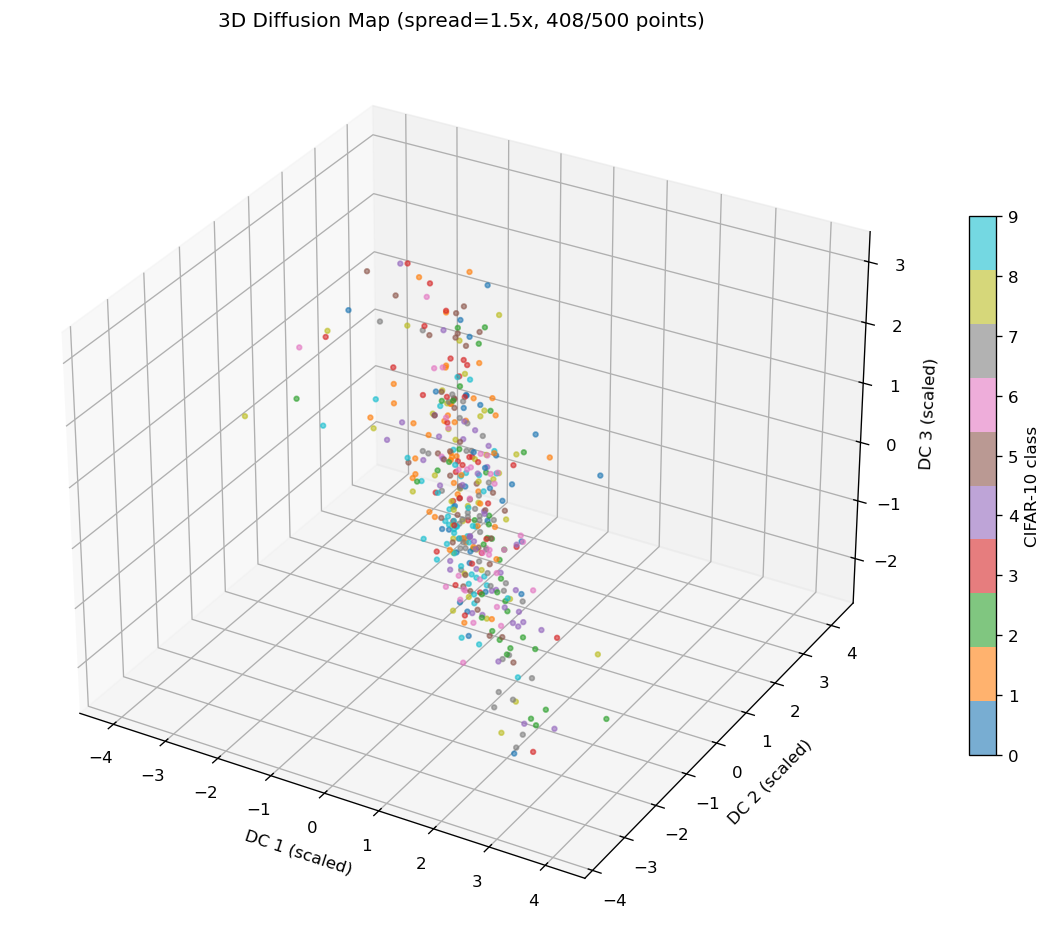

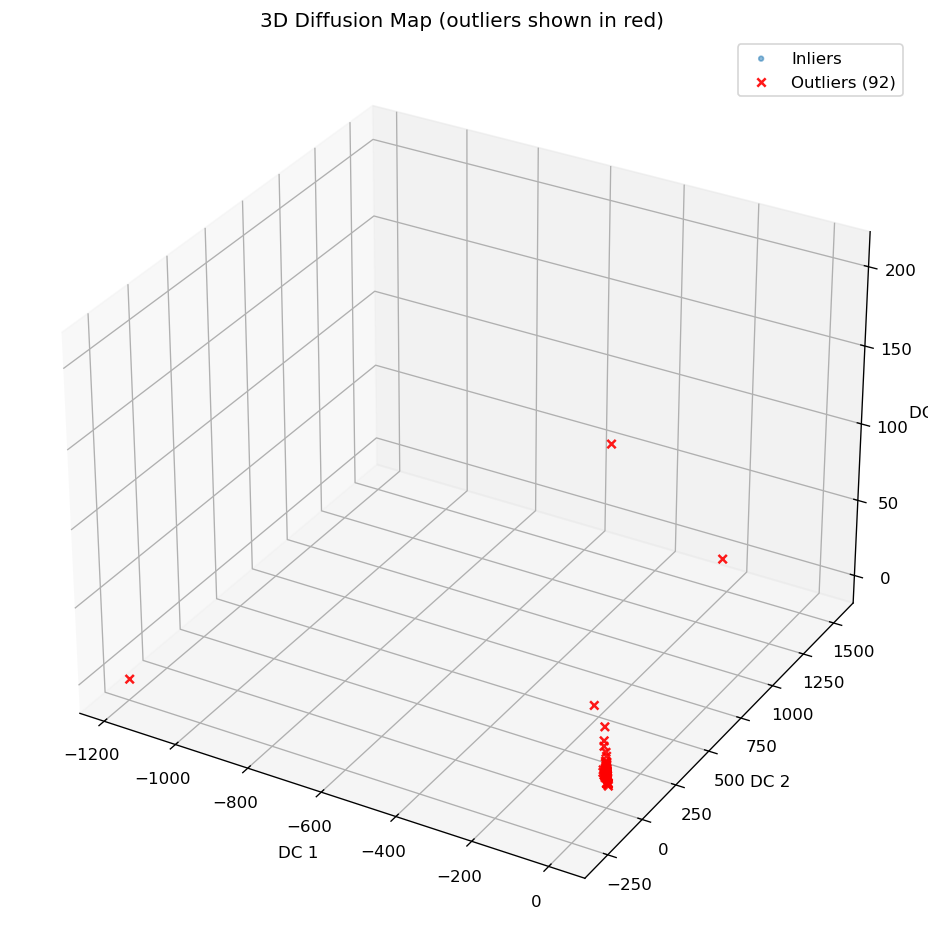

In [12]:
# 3D diffusion-coordinate visualization with GMM outlier filtering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D

# ============== RESCALE PARAMETER ==============
# Increase this value to spread clusters further apart
# Typical values: 1.0 (no change), 2.0-5.0 (moderate spread), 5.0-10.0 (large spread)
SPREAD_FACTOR = 1.5  # Slightly spread CIFAR clusters
# ===============================================

# Use first 3 nontrivial diffusion coordinates for 3D plot
# Scale by eigenvalues to get proper diffusion distances (standard practice)
dc_1_raw = phi[:, 1] * lam[1]
dc_2_raw = phi[:, 2] * lam[2]
dc_3_raw = phi[:, 3] * lam[3]
coords_3d_raw = np.column_stack([dc_1_raw, dc_2_raw, dc_3_raw])

print(f"Raw coordinate ranges (before filtering):")
print(f"  DC1: [{dc_1_raw.min():.4f}, {dc_1_raw.max():.4f}]")
print(f"  DC2: [{dc_2_raw.min():.4f}, {dc_2_raw.max():.4f}]")
print(f"  DC3: [{dc_3_raw.min():.4f}, {dc_3_raw.max():.4f}]")

# Step 1: First pass - use IQR to remove extreme outliers before GMM
def iqr_filter(data, factor=3.0):
    """Remove points outside factor*IQR from Q1/Q3"""
    q1 = np.percentile(data, 25, axis=0)
    q3 = np.percentile(data, 75, axis=0)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = np.all((data >= lower) & (data <= upper), axis=1)
    return mask

iqr_mask = iqr_filter(coords_3d_raw, factor=2.5)
print(f"\nIQR pre-filter: removed {np.sum(~iqr_mask)} extreme points ({100*np.sum(~iqr_mask)/len(iqr_mask):.1f}%)")

# Step 2: Fit GMM on IQR-filtered data for finer outlier detection
coords_filtered = coords_3d_raw[iqr_mask]
n_gmm_components = 12
gmm = GaussianMixture(n_components=n_gmm_components, covariance_type='full', random_state=42)
gmm.fit(coords_filtered)

# Score ALL points with the GMM trained on filtered data
log_probs_all = gmm.score_samples(coords_3d_raw)
# Use a more aggressive threshold: bottom 10% of GMM scores
threshold = np.percentile(log_probs_all[iqr_mask], 10)
gmm_mask = log_probs_all >= threshold

# Combine both filters
inlier_mask = iqr_mask & gmm_mask

print(f"GMM filter: removed additional {np.sum(iqr_mask & ~gmm_mask)} points")
print(f"Total outliers removed: {np.sum(~inlier_mask)} ({100*np.sum(~inlier_mask)/len(inlier_mask):.1f}%)")
print(f"Inliers kept: {np.sum(inlier_mask)}")

# Step 3: Standardize inliers, then apply SPREAD_FACTOR to increase separation
scaler = RobustScaler()  # More robust to remaining outliers
coords_inliers = coords_3d_raw[inlier_mask]
coords_scaled = scaler.fit_transform(coords_inliers)

# Apply spread factor: multiply by SPREAD_FACTOR to increase inter-cluster distances
coords_spread = coords_scaled * SPREAD_FACTOR

dc_1_plot, dc_2_plot, dc_3_plot = coords_spread[:, 0], coords_spread[:, 1], coords_spread[:, 2]

print(f"\nFiltered & scaled coordinate ranges (SPREAD_FACTOR={SPREAD_FACTOR}):")
print(f"  DC1: [{dc_1_plot.min():.3f}, {dc_1_plot.max():.3f}]")
print(f"  DC2: [{dc_2_plot.min():.3f}, {dc_2_plot.max():.3f}]")
print(f"  DC3: [{dc_3_plot.min():.3f}, {dc_3_plot.max():.3f}]")

# Plot 3D with inliers only (properly filtered and spread)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    dc_1_plot, dc_2_plot, dc_3_plot,
    c=labels_dm[inlier_mask], s=8, alpha=0.6, cmap="tab10"
)
ax.set_xlabel("DC 1 (scaled)")
ax.set_ylabel("DC 2 (scaled)")
ax.set_zlabel("DC 3 (scaled)")
ax.set_title(f"3D Diffusion Map (spread={SPREAD_FACTOR}x, {np.sum(inlier_mask)}/{len(inlier_mask)} points)")
fig.colorbar(scatter, ax=ax, label="CIFAR-10 class", shrink=0.6)
plt.tight_layout()
plt.show()

# Also show where outliers were (using same scaling)
scaler_all = RobustScaler().fit(coords_3d_raw[inlier_mask])
coords_all_scaled = scaler_all.transform(coords_3d_raw) * SPREAD_FACTOR
dc_1_all, dc_2_all, dc_3_all = coords_all_scaled[:, 0], coords_all_scaled[:, 1], coords_all_scaled[:, 2]

fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(
    dc_1_all[inlier_mask], dc_2_all[inlier_mask], dc_3_all[inlier_mask],
    c=labels_dm[inlier_mask], s=8, alpha=0.5, cmap="tab10", label="Inliers"
)
ax2.scatter(
    dc_1_all[~inlier_mask], dc_2_all[~inlier_mask], dc_3_all[~inlier_mask],
    c='red', s=25, alpha=0.9, marker='x', label=f"Outliers ({np.sum(~inlier_mask)})"
)
ax2.set_xlabel("DC 1")
ax2.set_ylabel("DC 2")
ax2.set_zlabel("DC 3")
ax2.set_title("3D Diffusion Map (outliers shown in red)")
ax2.legend()
plt.tight_layout()
plt.show()

In [13]:
# Compute diffusion-space mean and covariance for Gaussian diagnostics
num_dc = 16  # number of nontrivial diffusion coords to use (<= m-1)
Y_dm = phi[:, 1:1 + num_dc]
print("Diffusion-space data shape:", Y_dm.shape)

mu_Y = np.mean(Y_dm, axis=0)
cov_Y = np.cov(Y_dm.T)

print("Mean in diffusion space:", mu_Y)
print("Covariance shape:", cov_Y.shape)

Diffusion-space data shape: (500, 9)
Mean in diffusion space: [ 1.14352972e-16 -9.74775816e-17 -2.17603713e-17  2.44249065e-18
  8.32667268e-19  3.33066907e-19  1.47104551e-18  2.99760217e-18
 -8.43769499e-18]
Covariance shape: (9, 9)


## KSWGD-based latent generation
Following the KSWGD workflow from Tests 1 & 2, we now treat the autoencoder latents as the target samples and run Wasserstein gradient dynamics directly in latent space. Diffusion maps remain available above for visualization, but the sampling path below no longer uses the Gaussian model.

In [14]:
# Standardize DM latents and build the KSWGD kernel operators
# NOTE: Z_dm is already standardized in Cell 11, so we use it directly
X_tar = Z_dm.astype(np.float64)  # target samples for KSWGD (already standardized)
sq_tar = np.sum(X_tar ** 2, axis=1)

kswgd_dists = pairwise_distances(X_tar, metric="euclidean")
eps_kswgd = np.median(kswgd_dists**2) / (2.0 * np.log(X_tar.shape[0] + 1))
eps_kswgd = float(max(eps_kswgd, 1e-6))
data_kernel = np.exp(-kswgd_dists**2 / (2.0 * eps_kswgd))

p_x = np.sqrt(np.sum(data_kernel, axis=1))
data_kernel_norm = data_kernel / (p_x[:, None] * p_x[None, :] + 1e-12)
D_y = np.sum(data_kernel_norm, axis=0)
rw_kernel = 0.5 * (data_kernel_norm / (D_y + 1e-12) + data_kernel_norm / (D_y[:, None] + 1e-12))
# rw_kernel = data_kernel_norm / (D_y[:, None] + 1e-12)
rw_kernel = np.nan_to_num(rw_kernel)

print("KSWGD target shape:", X_tar.shape)
print("KSWGD epsilon:", eps_kswgd)

KSWGD target shape: (500, 64)
KSWGD epsilon: 10.071771320243366


In [15]:
# Build spectral quantities and KSWGD weights
import time
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create progress bar widget
progress_bar = widgets.FloatProgress(
    value=0, min=0, max=100, 
    description='Computing:', 
    bar_style='info',
    style={'bar_color': '#00a0dc', 'description_width': '80px'},
    layout=widgets.Layout(width='80%')
)
status_label = widgets.HTML(value="<b>Starting KSWGD computation...</b>")
time_label = widgets.HTML(value="")
display(widgets.VBox([progress_bar, status_label, time_label]))

start_time = time.time()

# Phase 1: Eigenvalue decomposition (GPU accelerated if available)
progress_bar.value = 10
use_gpu_eigh = torch.cuda.is_available()
if use_gpu_eigh:
    status_label.value = "<b>Phase 1/5:</b> Computing eigenvalue decomposition (GPU)..."
    rw_kernel_torch = torch.from_numpy(rw_kernel).to(device)
    lambda_ns_torch, phi_torch = torch.linalg.eigh(rw_kernel_torch)
    # Transfer back to CPU/numpy and reverse order (eigh returns ascending order)
    lambda_ns = lambda_ns_torch.cpu().numpy()[::-1].copy()
    phi = phi_torch.cpu().numpy()[:, ::-1].copy()
    del rw_kernel_torch, lambda_ns_torch, phi_torch
    torch.cuda.empty_cache()
else:
    status_label.value = "<b>Phase 1/5:</b> Computing eigenvalue decomposition (CPU)..."
    lambda_ns, phi = np.linalg.eigh(rw_kernel)
    phi = phi[:, ::-1]
    lambda_ns = lambda_ns[::-1]

eigh_time = time.time() - start_time
time_label.value = f"<i>Eigenvalue decomposition: {eigh_time:.1f}s ({'GPU' if use_gpu_eigh else 'CPU'})</i>"

# Phase 2: Setting up parameters
progress_bar.value = 30
status_label.value = "<b>Phase 2/5:</b> Setting up regularization parameters..."
tol = 1e-6
reg = 1e-3
# lambda_ = -lambda_ns + 1.0
lambda_ = lambda_ns - 1.0
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1.0 / np.clip(lambda_[1:], 1e-12, None)
inv_lambda *= eps_kswgd

# Phase 3: Computing inverse eigenvalues
progress_bar.value = 50
status_label.value = "<b>Phase 3/5:</b> Computing inverse eigenvalues..."
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = eps_kswgd / (lambda_ns[mask] + reg)
above_tol = int(np.sum(mask))
phi_trunc = phi[:, :above_tol]
lambda_ns_s_ns = (lambda_ns_inv * inv_lambda * lambda_ns_inv)[:above_tol]

# Phase 4: Computing target distribution
progress_bar.value = 70
status_label.value = "<b>Phase 4/5:</b> Computing target distribution..."
p_tar = np.sum(data_kernel, axis=0)
sqrt_p = np.sqrt(p_tar + 1e-12)
D_vec = np.sum(data_kernel / sqrt_p[:, None] / sqrt_p[None, :], axis=1)

# Phase 5: Finalizing
progress_bar.value = 90
elapsed = time.time() - start_time
status_label.value = "<b>Phase 5/5:</b> Finalizing results..."

# Complete
progress_bar.value = 100
progress_bar.bar_style = 'success'
total_time = time.time() - start_time
status_label.value = "<b style='color: green;'>✓ Completed!</b>"
time_label.value = f"<i>Total time: {total_time:.1f}s (eigh: {eigh_time:.1f}s on {'GPU' if use_gpu_eigh else 'CPU'})</i>"

print(f"\n{'='*50}")
print(f"Eigenvalue decomposition: {'GPU' if use_gpu_eigh else 'CPU'} ({eigh_time:.1f}s)")
print("Retained eigenvectors for KSWGD:", above_tol)


Eigenvalue decomposition: GPU (0.2s)
Retained eigenvectors for KSWGD: 500


## EDMD dictionary-learning pipeline
We now replicate the TestÂ 2 EDMD workflow on the MNIST latents: learn a sparse dictionary on the standardized targets, build a stochastic DMD operator in the resulting feature space, and feed the Koopman spectrum into KSWGD for a third generative path. The next cells construct the KDE drift pairs that seed the dictionary stage.

In [16]:
# Define KSWGD sampler and decoding utilities (needed for both EDMD and DM paths)

def run_kswgd_sampler(num_particles=64, num_iters=400, step_size=0.05, rng_seed=0):
    """Transport a batch of latent particles toward the target distribution."""
    rng = np.random.default_rng(rng_seed)
    xp = cp if use_gpu_kswgd else np
    grad_fn = grad_ker1_gpu if use_gpu_kswgd else grad_ker1
    K_eval_fn = K_tar_eval_gpu if use_gpu_kswgd else K_tar_eval

    # Preallocate histories
    x_hist = xp.zeros((num_particles, latent_dim, num_iters), dtype=xp.float64)
    init_block = rng.normal(0.0, 1.0, size=(num_particles, latent_dim))
    x_hist[:, :, 0] = xp.asarray(init_block)

    # Shared tensors on the selected backend
    if use_gpu_kswgd:
        X_tar_dev = cp.asarray(X_tar)
        p_tar_dev = cp.asarray(p_tar)
        sq_tar_dev = cp.asarray(sq_tar)
        D_vec_dev = cp.asarray(D_vec)
        phi_trunc_dev = cp.asarray(phi_trunc)
        lambda_weights = cp.asarray(lambda_ns_s_ns)
    else:
        X_tar_dev = X_tar
        p_tar_dev = p_tar
        sq_tar_dev = sq_tar
        D_vec_dev = D_vec
        phi_trunc_dev = phi_trunc
        lambda_weights = lambda_ns_s_ns

    iterator = trange(num_iters - 1, desc="KSWGD", unit="step")
    for t in iterator:
        current = x_hist[:, :, t]
        grad_matrix = grad_fn(current, X_tar_dev, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        cross_matrix = K_eval_fn(X_tar_dev, current, p_tar_dev, sq_tar_dev, D_vec_dev, eps_kswgd)
        tmp = phi_trunc_dev.T @ cross_matrix
        tmp = lambda_weights[:, None] * tmp
        kswgd_push = phi_trunc_dev @ tmp

        for dim in range(latent_dim):
            sum_term = grad_matrix[:, :, dim] @ kswgd_push
            x_hist[:, dim, t + 1] = x_hist[:, dim, t] - (step_size / num_particles) * xp.sum(sum_term, axis=1)

        if (t + 1) % 50 == 0 or t + 1 == num_iters - 1:
            step_norm = x_hist[:, :, t + 1] - x_hist[:, :, t]
            mean_disp = float(xp.mean(xp.linalg.norm(step_norm, axis=1)))
            iterator.set_postfix({"mean_step": f"{mean_disp:.3e}"})

    samples_std = x_hist[:, :, -1]
    if use_gpu_kswgd:
        samples_std = cp.asnumpy(samples_std)
    return np.asarray(samples_std, dtype=np.float64)


def decode_latents(flat_latents: np.ndarray) -> torch.Tensor:
    """Decode flattened latent vectors back into RGB images."""
    autoencoder.eval()
    latents_tensor = torch.from_numpy(flat_latents).float().to(device)
    with torch.no_grad():
        decoded = autoencoder.decode(latents_tensor)
    return decoded.cpu()

EDMD training set size: (200, 64)
KDE bandwidth h: 11.2105
Training dictionary with 51 dictionary functions...
Computing sparse codes...
Solving for Koopman operator...
Koopman matrix shape: (51, 51)
Eigenvalues sorted by decreasing real part (top 10):
  0: real=+1.2495, imag=+0.0000, |λ|=1.2495
  1: real=+1.2347, imag=+0.0936, |λ|=1.2382
  2: real=+1.2347, imag=-0.0936, |λ|=1.2382
  3: real=+1.1634, imag=+0.1274, |λ|=1.1704
  4: real=+1.1634, imag=-0.1274, |λ|=1.1704
  5: real=+1.1435, imag=-0.1878, |λ|=1.1589
  6: real=+1.1435, imag=+0.1878, |λ|=1.1589
  7: real=+1.1394, imag=-0.0819, |λ|=1.1423
  8: real=+1.1394, imag=+0.0819, |λ|=1.1423
  9: real=+1.1302, imag=+0.0000, |λ|=1.1302


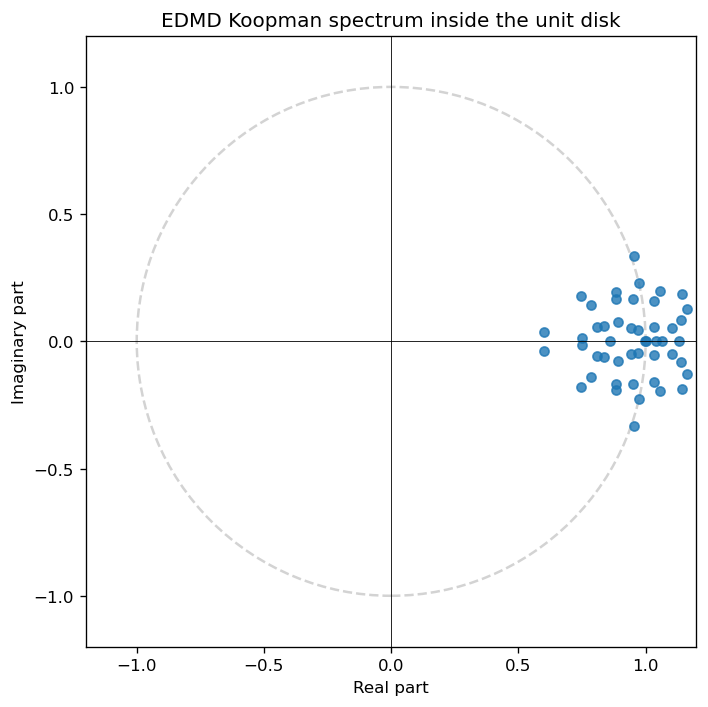


Running KSWGD using EDMD spectrum...
Extrapolating EDMD eigenfunctions to full target set (500 points)...
Using top 20 real modes for KSWGD.
Executing KSWGD sampler with EDMD basis...


KSWGD:   0%|          | 0/49 [00:00<?, ?step/s]

Generated EDMD samples: (16, 64)
Restored Diffusion Map globals.


In [17]:
# Construct EDMD dictionary and Koopman operator, then visualize spectrum
# This cell reconstructs the drift dynamics, learns the dictionary, and computes K_edmd

# =============================================================================
# 1. Setup data for EDMD (subsample for speed)
# =============================================================================
n_edmd_samples = 200  # DEBUG: reduced from 5000
if X_tar.shape[0] > n_edmd_samples:
    # Stratified subsample if labels available, else random
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=n_edmd_samples, random_state=42)
    idx_edmd, _ = next(splitter.split(X_tar, labels_dm))
    X_edmd = X_tar[idx_edmd]
    y_edmd_labels = labels_dm[idx_edmd]
else:
    X_edmd = X_tar
    y_edmd_labels = labels_dm

print(f"EDMD training set size: {X_edmd.shape}")

# =============================================================================
# 2. Compute KDE drift (score function)
# =============================================================================
# Bandwidth h via median heuristic on the subset
dists_edmd = pairwise_distances(X_edmd, metric="euclidean")
med_sq_edmd = np.median(dists_edmd**2)
h_bw = np.sqrt(med_sq_edmd)
print(f"KDE bandwidth h: {h_bw:.4f}")

# Compute weights W_ij = exp(-dist^2 / (2*h^2))
W = np.exp(-dists_edmd**2 / (2 * h_bw**2))
# Row normalize for mean shift
row_sums_W = W.sum(axis=1, keepdims=True)
P_W = W / row_sums_W

# Mean shift vector: m(x) = \sum P_ij x_j - x_i
drift = P_W @ X_edmd - X_edmd
# Score = m(x) / h^2
score = drift / (h_bw**2)

# =============================================================================
# 3. Generate pairs (X, Y)
# =============================================================================
dt = 0.1
noise_scale = np.sqrt(2 * dt)
noise = np.random.normal(0, 1, X_edmd.shape) * noise_scale
Y_edmd = X_edmd + score * dt + noise

# =============================================================================
# 4. Learn Dictionary
# =============================================================================
n_dict = 50  # DEBUG: reduced from 500
alpha_sparsity = 1.0
# FIX: Changed n_iter to max_iter for newer scikit-learn versions
dict_learner = MiniBatchDictionaryLearning(
    n_components=n_dict, alpha=alpha_sparsity, max_iter=20, batch_size=128, random_state=42, verbose=0
)
print(f"Training dictionary with {n_dict+1} dictionary functions...")
# Fit on both X and Y to cover the space
data_combined = np.vstack([X_edmd, Y_edmd])
dict_learner.fit(data_combined)

# =============================================================================
# 5. Compute features Psi(X), Psi(Y)
# =============================================================================
print("Computing sparse codes...")
Psi_X = dict_learner.transform(X_edmd)
Psi_Y = dict_learner.transform(Y_edmd)

# Add constant feature (for probability conservation/bias)
Psi_X = np.hstack([np.ones((Psi_X.shape[0], 1)), Psi_X])
Psi_Y = np.hstack([np.ones((Psi_Y.shape[0], 1)), Psi_Y])

# =============================================================================
# 6. Compute Koopman Operator K
# =============================================================================
# K = pinv(Psi_X) @ Psi_Y
print("Solving for Koopman operator...")
# Ridge regression for stability
lambda_reg = 1e-5
A = Psi_X.T @ Psi_X
B = Psi_X.T @ Psi_Y
A_reg = A + lambda_reg * np.eye(A.shape[0])
K_edmd = np.linalg.solve(A_reg, B)

print(f"Koopman matrix shape: {K_edmd.shape}")
koopman_matrix = K_edmd  # Set for visualization

# =============================================================================
# 7. Visualize Spectrum
# =============================================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(koopman_matrix)

# Sort by real part
sorted_idx = np.argsort(-eigvals.real)
eigvals_sorted = eigvals[sorted_idx]

print("Eigenvalues sorted by decreasing real part (top 10):")
for idx, val in enumerate(eigvals_sorted[:10]):
    print(f"{idx:3d}: real={val.real:+.4f}, imag={val.imag:+.4f}, |λ|={np.abs(val):.4f}")

fig, ax = plt.subplots(figsize=(6, 6))
unit_circle = Circle((0, 0), 1.0, color="lightgray", fill=False, linestyle="--", linewidth=1.5)
ax.add_patch(unit_circle)
ax.scatter(eigvals.real, eigvals.imag, c="tab:blue", s=30, alpha=0.8)
ax.set_xlabel("Real part")
ax.set_ylabel("Imaginary part")
ax.set_title("EDMD Koopman spectrum inside the unit disk")
ax.axhline(0, color="black", linewidth=0.5)
ax.axvline(0, color="black", linewidth=0.5)
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
plt.tight_layout()
plt.show()

# =============================================================================
# 8. Run KSWGD with EDMD Spectrum (Discarding Imaginary Parts)
# =============================================================================
print("\n" + "="*50)
print("Running KSWGD using EDMD spectrum...")

# 1. Extract Real Parts of Eigenvalues and Eigenfunctions
# Sort eigenvectors to match sorted eigenvalues
eigvecs_sorted = eigvecs[:, sorted_idx]

# CRITICAL FIX: Evaluate eigenfunctions on the FULL X_tar dataset
# The KSWGD sampler uses X_tar (20k points) for kernel computations,
# so phi_trunc must match that first dimension (20k), not just X_edmd (5k).
print(f"Extrapolating EDMD eigenfunctions to full target set ({X_tar.shape[0]} points)...")
Psi_tar = dict_learner.transform(X_tar)
Psi_tar = np.hstack([np.ones((Psi_tar.shape[0], 1)), Psi_tar])

# Compute eigenfunctions on the data: Phi = Psi @ V
Phi_edmd_complex = Psi_tar @ eigvecs_sorted

# Take Real Parts (Discard Imaginary)
lambda_edmd_real = np.real(eigvals_sorted)
Phi_edmd_real = np.real(Phi_edmd_complex)

# 2. Select top modes for KSWGD
# We skip the first trivial mode (lambda=1, constant function) if it dominates,
# but KSWGD logic usually handles it via the regularization.
# Let's keep top 80 modes as suggested in notes.
n_modes_edmd = 20  # DEBUG: reduced from 80
lambda_edmd_trunc = lambda_edmd_real[:n_modes_edmd]
phi_edmd_trunc = Phi_edmd_real[:, :n_modes_edmd]

print(f"Using top {n_modes_edmd} real modes for KSWGD.")

# 3. Compute Spectral Weights (Regularization)
# Replicating the logic from Cell 18 but for EDMD eigenvalues
# lambda_ns_s_ns = (lambda_inv * inv_lambda * lambda_inv)
# where inv_lambda ~ 1/lambda (with epsilon scaling)

tol = 1e-6
reg = 1e-3

# Inverse eigenvalues with regularization
lambda_inv_edmd = np.zeros_like(lambda_edmd_trunc)
mask_edmd = np.abs(lambda_edmd_trunc) >= tol
lambda_inv_edmd[mask_edmd] = eps_kswgd / (lambda_edmd_trunc[mask_edmd] + reg)

# The "inv_lambda" term from Cell 18 (approx 1/lambda)
# Note: In Cell 18, lambda_ = lambda_ns - 1.0 was used for some reason,
# but standard KSWGD often uses just 1/lambda. Let's stick to the structure:
# inv_lambda[1:] = 1.0 / lambda[1:]
inv_lambda_edmd = np.zeros_like(lambda_edmd_trunc)
inv_lambda_edmd[1:] = 1.0 / np.clip(lambda_edmd_trunc[1:], 1e-12, None)
inv_lambda_edmd *= eps_kswgd

# Combined weights
lambda_weights_edmd = (lambda_inv_edmd * inv_lambda_edmd * lambda_inv_edmd)

# 4. Swap Globals and Run Sampler
# Backup Diffusion Map globals
phi_trunc_backup = phi_trunc
lambda_weights_backup = lambda_ns_s_ns

try:
    # Inject EDMD globals
    phi_trunc = phi_edmd_trunc
    lambda_ns_s_ns = lambda_weights_edmd
    
    # Run Sampler
    print("Executing KSWGD sampler with EDMD basis...")
    kswgd_config_edmd = dict(num_particles=16, num_iters=50, step_size=0.03, rng_seed=2)  # DEBUG: reduced
    Z_new_kswgd_edmd_std = run_kswgd_sampler(**kswgd_config_edmd)
    
    # Un-standardize
    Z_new_kswgd_edmd = Z_new_kswgd_edmd_std * Z_dm_std + Z_dm_mean
    print(f"Generated EDMD samples: {Z_new_kswgd_edmd.shape}")
    
finally:
    # Restore Diffusion Map globals so other cells don't break
    phi_trunc = phi_trunc_backup
    lambda_ns_s_ns = lambda_weights_backup
    print("Restored Diffusion Map globals.")

In [18]:
# Optionally decode EDMD + KSWGD latent vectors if they are defined
if "Z_new_kswgd_edmd" not in globals():
    print("EDMD-based latent samples not available; skipping this cell.")
else:
    edmd_images = decode_latents(Z_new_kswgd_edmd)
    edmd_images_cpu = edmd_images.numpy()
    print("EDMD-KSWGD images shape:", edmd_images_cpu.shape)

EDMD-KSWGD images shape: (16, 3, 32, 32)


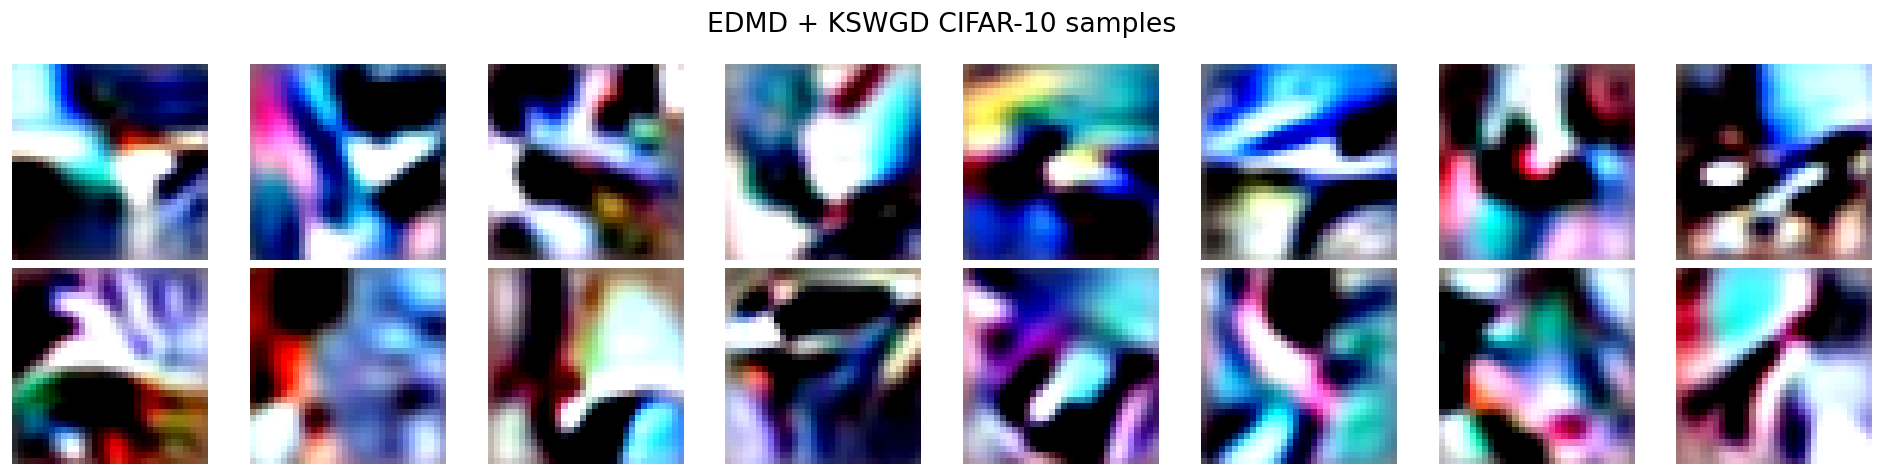

In [19]:
# Visualize EDMD + KSWGD samples when available
if "edmd_images_cpu" not in globals():
    print("No EDMD reconstructions to display.")
else:
    n_cols_edmd = 8
    n_rows_edmd = max(1, edmd_images_cpu.shape[0] // n_cols_edmd)
    n_show_edmd = n_rows_edmd * n_cols_edmd
    fig, axes = plt.subplots(n_rows_edmd, n_cols_edmd, figsize=(2 * n_cols_edmd, 2 * n_rows_edmd))
    axes = np.asarray(axes).reshape(n_rows_edmd, n_cols_edmd)
    for idx in range(n_show_edmd):
        ax = axes[idx // n_cols_edmd, idx % n_cols_edmd]
        img = np.transpose(edmd_images_cpu[idx], (1, 2, 0))
        ax.imshow(np.clip(img, 0.0, 1.0))
        ax.axis("off")
    plt.suptitle("EDMD + KSWGD CIFAR-10 samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Technical Notes & Parameter Reference
---
## 1. Dataset, Autoencoder & Dataloaders
- **Dataset:** CIFAR-10 (32×32 RGB) loaded via `transforms.ToTensor()` with no additional normalization.
- **Batch size:** 128 for both training and validation loaders to keep GPU RAM predictable.
- **Latent model:** Pretrained `stabilityai/sd-vae-ft-mse` `AutoencoderKL` wrapped in `DiffusersAutoencoderWrapper`. Encoder blocks are frozen except the final down block, matching the CIFAR-10 distribution without extra fine-tuning by default.
- **Latent dimension:** Determined dynamically (`latent_dim = autoencoder.latent_dim`, ~64 for 32×32 inputs).
- **Scaling:** The diffusers VAE uses scaling factor $s$ so encoder/decoder follow
  $$z = s \cdot \text{mode}(\mathcal{E}(2x-1)), \qquad x = \operatorname{clip}\left(\frac{\mathcal{D}(z/s)+1}{2}, 0, 1\right).$$
---
## 2. Latent Collection & Diffusion Maps
1. **Latent harvesting:** Iterate through the CIFAR-10 training loader, collecting latent vectors $Z \in \mathbb{R}^{N\times d}$ and class labels.
2. **Sampling budget:** `max_dm_samples = 20000` via stratified `StratifiedShuffleSplit` to keep class balance.
3. **Standardization:**
   $$Z_{dm} = \frac{Z_{raw} - \mu_{dm}}{\sigma_{dm}+10^{-8}}$$
4. **Kernel + Markov matrix:** Pairwise distances on $Z_{dm}$ feed a Gaussian kernel with bandwidth
   $$\epsilon = \frac{\text{median}(d_{ij}^2)}{2\ln N}, \quad K_{ij} = \exp\Big(-\frac{d_{ij}^2}{2\epsilon}\Big), \quad P = D^{-1}K.$$
5. **Eigenproblem:** `m = 32` leading eigenpairs of $P^T$ (diffusion time `t_diffusion = 1`).
6. **Diagnostics:**
   - 2D scatter keeps top $85\%$ GMM likelihood mass (`n_gmm_components_2d = 10`).
   - 3D visualization spreads clusters with `SPREAD_FACTOR = 1.5`, IQR filtering, and a 12-component GMM removing the weakest 10% log-likelihood tail.
7. **Moment stats:** `num_dc = 16` diffusion coordinates feed the Gaussian diagnostics and downstream summaries.
---
## 3. KSWGD Target Construction
- **Target samples:** `X_tar = Z_dm` (already standardized).
- **Bandwidth:**
  $$\epsilon_{kswgd} = \max\left(\frac{\text{median}(d_{ij}^2)}{2\ln(N+1)}, 10^{-6}\right).$$
- **Random-walk kernel:**
  1. `p_x = sqrt(sum_j K_ij)`
  2. `data_kernel_norm = K / (p_x p_x^T)`
  3. Symmetrize to obtain `rw_kernel`, ensuring numerical stability with `np.nan_to_num`.
- **Spectral prep:** retain eigenmodes with `tol = 1e-6`, apply `reg = 1e-3`, and reuse `phi_trunc`, `lambda_ns_s_ns` on both CPU and CuPy backends.
---
## 4. Baseline KSWGD Transport (Diffusion-Map Path)
| Hyper-parameter | Value | Notes |
| --- | --- | --- |
| `num_particles` | 128 | More particles for the higher-dimensional CIFAR latent |
| `num_iters` | 600 | Longer run stabilizes transport |
| `step_size` | 0.03 | Conservative step for the SD-VAE latent geometry |
| `rng_seed` | 1 | NumPy RNG seed for deterministic initialization |
| Backend | CPU or CuPy | auto-selects GPU kernels when available |
Workflow: initialize $x^{(0)} \sim \mathcal{N}(0, I)$, iterate
$$x^{(t+1)} = x^{(t)} - \frac{\eta}{m}\sum_j \nabla_x K(x^{(t)}, X_{tar})_{:,j}\; \Phi\Lambda\Phi^T K(X_{tar}, x^{(t)})_j,$$
then un-standardize via $x = x_{std}\,\sigma_{dm} + \mu_{dm}$ and decode with the pretrained VAE. The resulting tensor (`dm_images_cpu`) drives the CIFAR-10 grids.
---
## 5. Hyper-parameter Sweep
- **Seeds:** `[1, 2, 3]`
- **Particles:** `[64, 128]`
- **Step sizes:** `[0.02, 0.04, 0.06]`
- **Iterations:** `[400, 600]`
All $3\times2\times3\times2 = 36$ configurations are evaluated. Each run prints the configuration, produces a color grid (16 columns), and reports the decoded tensor shape for bookkeeping.
---
## 6. Koopman / EDMD Notes (Placeholder)
Although the EDMD dictionary-learning path is currently disabled, re-enabling it will produce a Koopman operator $\mathbf{K} \in \mathbb{R}^{(K+1) \times (K+1)}$, where $K$ is the number of dictionary atoms and the extra row/column correspond to the constant observable. For the prior MNIST setup (`n_dict_components = 100`), this yields a 101×101 matrix. When adapting to CIFAR-10 you can safely double the atom count (e.g., 200) and keep the top $\approx 80$ eigenmodes after thresholding at $10^{-6}$ to supply richer spectra to KSWGD. Adjust `m` in the diffusion-map cell in tandem so the Koopman truncation has enough signal.
---
## 7. Reproducibility Checklist
1. Configure seeds (`np.random.seed(1)`, `torch.manual_seed(1)`) and device detection.
2. Run dataset + VAE setup cells (1–7).
3. Gather latents and execute diffusion-map diagnostics (Cells 11–16) with `m = 32`.
4. Build KSWGD kernels and spectra (Cells 17–18).
5. Execute the baseline sampler (Cell 19) to populate `dm_images_cpu`.
6. Run the sweep (Cell 23) or re-enable the EDMD track as needed.